In [1]:
import numpy as np
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape
from keras.layers import Input
from keras.losses import mean_squared_error
from keras.optimizers import Adam

from utils import LossHistory, plotHistory, visualization
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.cifar import dataGenerator

Using TensorFlow backend.


# Parameters

In [2]:
num_class = 10
input_shape = (32, 32, 3)

batch_size = 32

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [3]:
trainGenerator = dataGenerator('train', batch_size=batch_size, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size)

170500096/170498071 [==============================] - 12s 0us/step


# Model

In [4]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=256, kernel_size=(9, 9), activation='relu') (x)
encoder = PrimaryCaps(capsules=32, capsule_dim=8, kernel_size=(9, 9), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=10, capsule_dim=16, routings=3, activation_caps=squash) (encoder)

output = ClassesCaps(name='capsule') (encoder)

decoder = Mask() (encoder, y_true=y)
decoder = Dense(512, activation='relu') (decoder)
decoder = Dense(1024, activation='relu') (decoder)
decoder = Dense(3072, activation='sigmoid') (decoder)
decoder = Reshape((input_shape), name='reconstruction') (decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])
model = Model(inputs=x, outputs=output)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 256)       62464     
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 2048, 8)           5308672   
_________________________________________________________________
caps_1 (Caps)                (None, 10, 16)            2621440   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 7,992,576
Trainable params: 7,992,576
Non-trainable params: 0
_________________________________________________________________


# Training

In [6]:
model_training.compile(loss=[margin(), mean_squared_error],
                        loss_weights=[1, 0.0005],
                        optimizer=Adam(lr=1e-3),
                        metrics={'capsule': 'accuracy'})

In [7]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))
hist = model_training.fit_generator(trainGenerator,
                                    steps_per_epoch=50000 // batch_size,
                                    epochs=10,
                                    validation_data=testGenerator,
                                    validation_steps=10000 // batch_size,
                                    verbose=2,
                                    callbacks=[history])

Epoch 1/10
 - 382s - loss: 0.0027 - capsule_loss: 0.0027 - reconstruction_loss: 0.0633 - capsule_acc: 0.1189 - val_loss: 3.0863e-05 - val_capsule_loss: 3.9077e-08 - val_reconstruction_loss: 0.0616 - val_capsule_acc: 0.1034
Epoch 2/10
 - 347s - loss: 3.9607e-05 - capsule_loss: 9.3397e-06 - reconstruction_loss: 0.0605 - capsule_acc: 0.1150 - val_loss: 2.9300e-05 - val_capsule_loss: 5.6093e-08 - val_reconstruction_loss: 0.0585 - val_capsule_acc: 0.1338
Epoch 3/10
 - 347s - loss: 3.7266e-05 - capsule_loss: 8.0437e-06 - reconstruction_loss: 0.0584 - capsule_acc: 0.1219 - val_loss: 2.9390e-05 - val_capsule_loss: 4.0377e-07 - val_reconstruction_loss: 0.0580 - val_capsule_acc: 0.1582
Epoch 4/10
 - 347s - loss: 4.2732e-05 - capsule_loss: 1.3598e-05 - reconstruction_loss: 0.0583 - capsule_acc: 0.1236 - val_loss: 2.9476e-05 - val_capsule_loss: 5.1823e-07 - val_reconstruction_loss: 0.0579 - val_capsule_acc: 0.1757
Epoch 5/10
 - 347s - loss: 3.4673e-05 - capsule_loss: 5.6271e-06 - reconstruction_lo

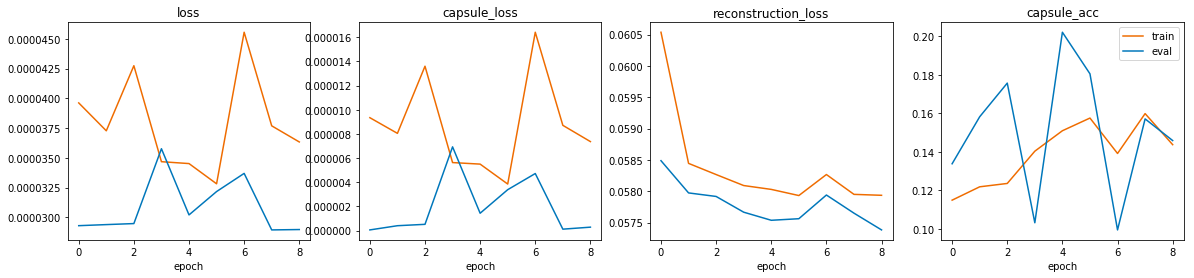

In [8]:
plotHistory(history.metrics)

# Visualization

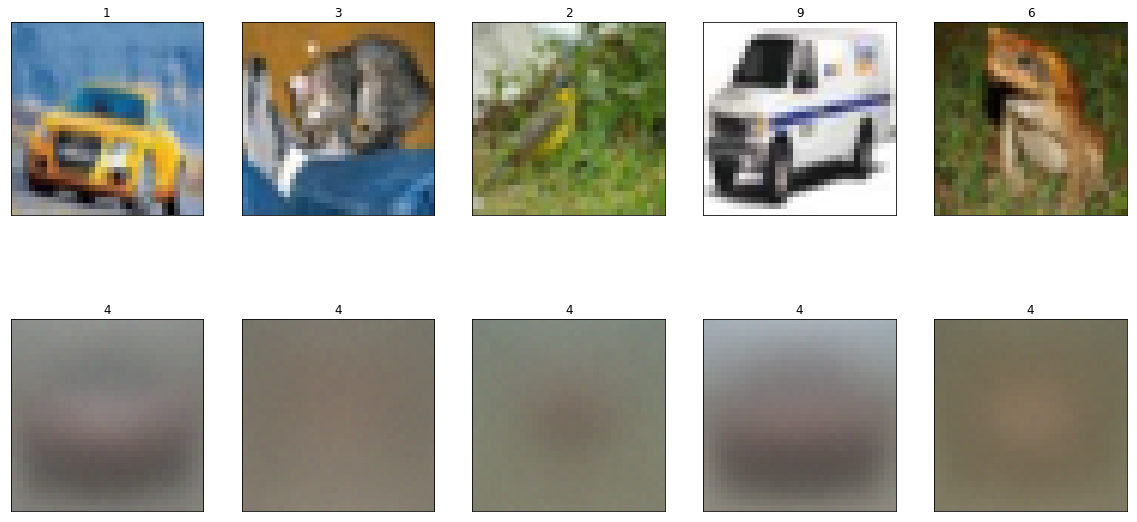

In [10]:
n_image = 5

# Select data
images, labels = next(dataGenerator('test', batch_size=n_image, reshape=False))

# Run inference
classes, reconstructions = model_training.predict([images, labels])

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)

visualization((images, labels), (reconstructions, predictions))